In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import numpy as np

def dateparse(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)

data = pd.read_csv('/home/maksym/2021-knu-market/data/[1h]BTCUSDT.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)

data.head()

,Start,Stop,Open,Close,Low,High,Volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


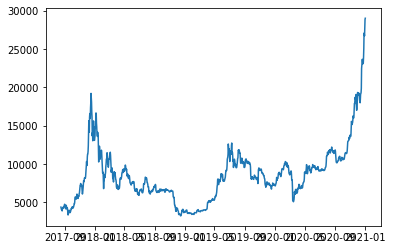

In [2]:
dataOpen = data[['Start','Open']]

dataOpen = dataOpen.set_index('Start')
dataOpen = dataOpen.resample('24H').mean() #Open mean price per day

date = dataOpen.index #list of dates

range_ = pd.RangeIndex(0, len(dataOpen)) 

dataOpen = dataOpen.set_index(range_) 
plt.plot(date, dataOpen) #non-stationary


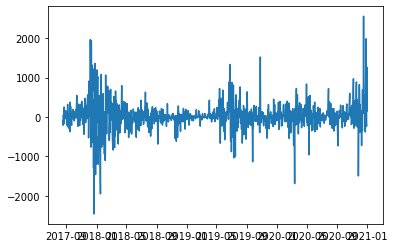

In [47]:
dataOpen_stat = dataOpen.diff(periods=1).dropna() #stationary
plt.plot(date[1:], dataOpen_stat)

In [55]:
from pmdarima import auto_arima

f = auto_arima(dataOpen_stat)
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1233
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -8907.416
Date:                Wed, 10 Feb 2021   AIC                          17822.832
Time:                        21:18:07   BIC                          17843.297
Sample:                             0   HQIC                         17830.531
                               - 1233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2312      0.017     13.693      0.000       0.198       0.264
ar.L2         -0.0499      0.014     -3.524      0.000      -0.078      -0.022
ma.L1         -0.9863      0.004   -255.525      0.000      -0.994      -0.979
sigma2      1.113e+05   1876.143     59.305      0.000    1.08e+05    1.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5020.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

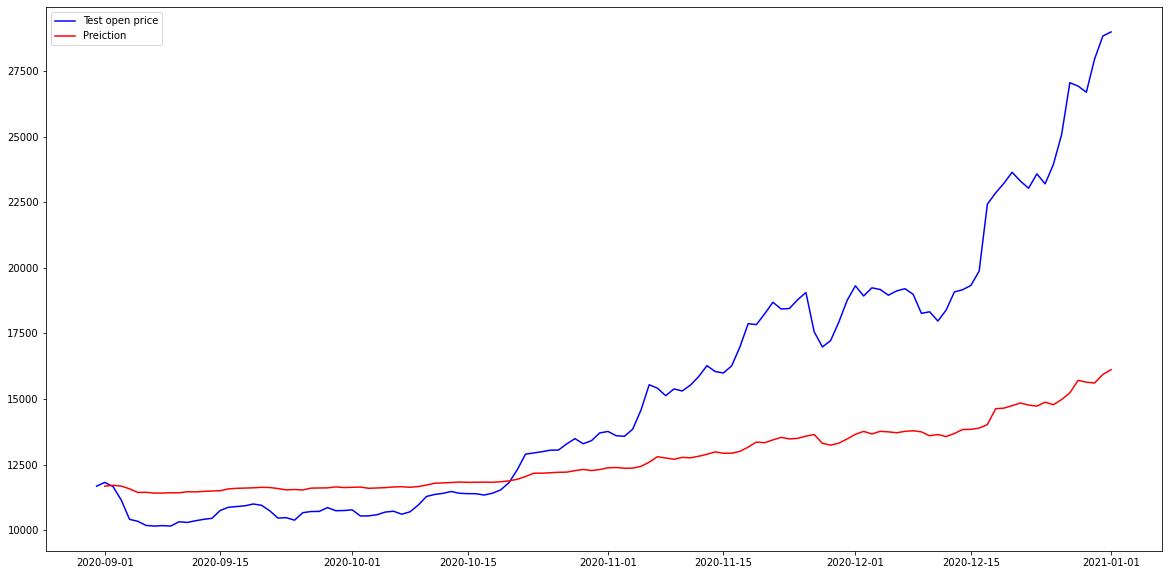

In [71]:
#ARMA


from statsmodels.tsa.arima.model import ARIMA

len_ = int(len(dataOpen)*0.9)
#train and test on stationary series
train, test = dataOpen_stat[:len_].Open.tolist(), dataOpen_stat[len_:].Open.tolist()
predict_arma = []

for i in range(len(test)):
    
    m = ARIMA(train, order=(1,0,1)).fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_arma.append(p)

#predict non-stationary series
predict_arma_renewed = np.zeros(len(predict_arma))
predict_arma_renewed [0] = dataOpen[len_:len_+1].values

for i in range(1,len(predict_arma)):
    predict_arma_renewed[i] = predict_arma[i] +  predict_arma_renewed[i-1]
plt.figure(figsize=(20,10))

plt.plot(date[len_:],dataOpen[len_:], 'b', label='Test open price')
plt.plot([i for i in date[len_+1:]],predict_arma_renewed, 'r', label='Preiction')
plt.legend()



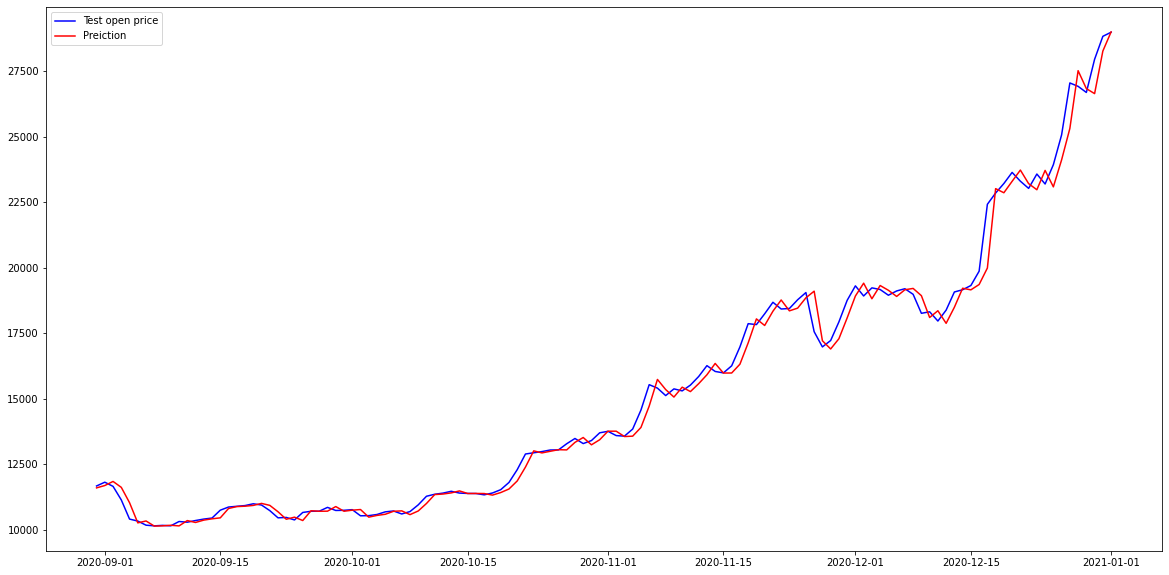

In [69]:
#ARIMA

from statsmodels.tsa.arima.model import ARIMA

len_ = int(len(dataOpen)*0.9)
train, test = dataOpen[:len_].Open.tolist(), dataOpen[len_:].Open.tolist()
predict_arima = []

for i in range(len(test)):
    
    m = ARIMA(train, order=(1,1,1)).fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_arima.append(p)

plt.figure(figsize=(20,10))

plt.plot(date[len_:],train[len_:], 'b',label='Test open price')
plt.plot([i for i in date[len_:]],predict_arima, 'r',label='Preiction')
plt.legend()

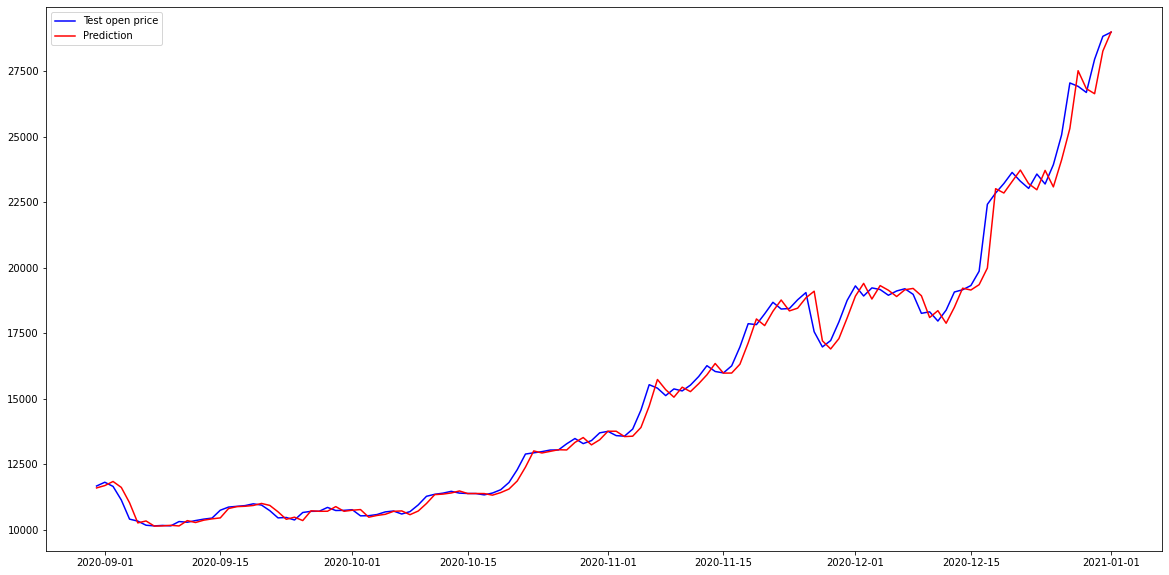

In [72]:
#SARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX


len_ = int(len(dataOpen)*0.9)
train, test = dataOpen[:len_].Open.tolist(), dataOpen[len_:].Open.tolist()
predict_sarima = []
for i in range(len(test)):
    
    m = SARIMAX(train, order=(2,1,1)).fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_sarima.append(p)

plt.figure(figsize=(20,10))

plt.plot(date[len_:],train[len_:], 'b', label='Test open price')
plt.plot([i for i in date[len_:]],predict_sarima, 'r', label='Prediction')
plt.legend()

In [77]:
from sklearn.metrics import mean_absolute_error

print('ARMA mean absolute error : ', mean_absolute_error(dataOpen[len_+1:], predict_arma_renewed))
print('ARIMA mean absolute error : ',  mean_absolute_error(dataOpen[len_:], predict_arima))
print('SARIMA mean absolute error : ', mean_absolute_error(dataOpen[len_:], predict_sarima))

ARMA mean absolute error :  3236.0393054879714
ARIMA mean absolute error :  286.7041455992443
SARIMA mean absolute error :  287.0392293790956
